In [2]:
#--- Imports ---#

import os
import random
import tensorflow as tf

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Input, Embedding, Bidirectional, LSTM, \
                         BatchNormalization, Dropout, GlobalMaxPooling1D, Dense, dot
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam


from time import time
from keras.callbacks import Callback, LearningRateScheduler, EarlyStopping

# import torch
# from torch import nn

import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#--- Set Random Seed ---#

WORD = "meow"
seed = sum(ord(char) for char in WORD)
np.random.seed(seed)
random.seed(seed)
# torch.manual_seed(seed)
tf.random.set_seed(seed)

In [4]:
#--- Constants ---#

RAND_STATE = 42     # Random State.
TRAIN_SIZE = 0.002  # Size of Training Dataset.
TEST_SIZE  = 0.5    # Size of Test Dataset.

EMBED_DIM  = 100    # Embedding Dimensions of Pretrained Embedding Model.
LSTM_CELLS = 16     # Number of LSTM cells for LSTM layer.
DROPOUT    = 0.5    # Dropout Rate for Dropout Layer.
DENSE_DIM  = 16     # Dimensions of Dense Layer.
DISC_STEPS = 1      # Number of Discriminator Steps.

NOISE_DIM  = 16    # Dimension of Random Noise Vector.
LEARN_RATE = 0.001  # Initial Learning Rate.
LR_DECAY   = 0.95   # Learning Rate Decay.
PATIENCE   = 10     # Early Stopping Patience.
EPOCHS     = 10000  # Number of training epochs.
BATCH_SIZE = 8      # Training Batch Size.

In [5]:
#--- Read Data ---#

df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv") # Read from .csv file.
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
#--- Label Encoding ---#

df.sentiment = df.sentiment.apply(lambda x: 1 if x=='positive' else 0) # Convert sentiment to numerical values.
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [7]:
#--- Split Data ---#

df_train, df_temp = train_test_split(df, test_size=(1-TRAIN_SIZE), random_state=RAND_STATE, stratify=df['sentiment'])
df_val,   df_test = train_test_split(df_temp, test_size=TEST_SIZE, random_state=RAND_STATE, stratify=df_temp['sentiment'])

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#--- Check Class Distribution ---#

print(df_train.value_counts('sentiment'))
print(df_val.value_counts('sentiment'))
print(df_test.value_counts('sentiment'))

#--- Split Input and Labels ---#

X_train = df_train['review']
y_train = df_train['sentiment']
X_val   = df_val['review']
y_val   = df_val['sentiment']
X_test  = df_test['review']
y_test  = df_test['sentiment']

sample_size = len(X_train)

sentiment
0    50
1    50
Name: count, dtype: int64
sentiment
0    12475
1    12475
Name: count, dtype: int64
sentiment
0    12475
1    12475
Name: count, dtype: int64


In [8]:
#--- Tokenization ---#

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val   = tokenizer.texts_to_sequences(X_val)
X_test  = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

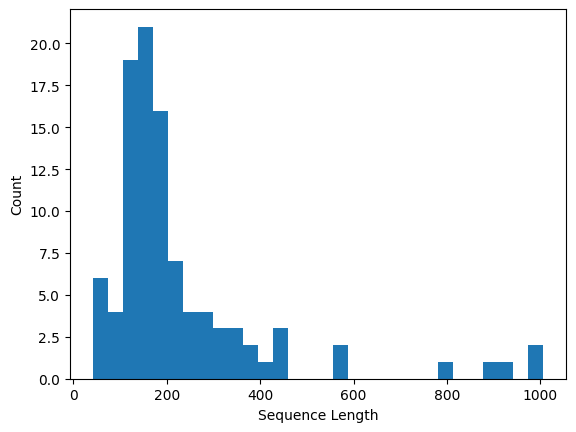

Mean sequence length: 230.57
Median sequence length: 168.5
Max sequence length: 1007
95th percentile sequence length: 570.4499999999994


In [9]:
#--- Plot Sequence Lengths ---#

sequence_lengths = [len(seq) for seq in X_train]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Median sequence length: {np.median(sequence_lengths)}")
print(f"Max sequence length: {max(sequence_lengths)}")
print(f"95th percentile sequence length: {np.percentile(sequence_lengths, 95)}")

In [10]:
#--- Sequence Padding ---#

sequence_length = int(np.percentile(sequence_lengths, 95))

X_train = pad_sequences(X_train, maxlen=sequence_length)
X_val   = pad_sequences(X_val, maxlen=sequence_length)
X_test  = pad_sequences(X_test, maxlen=sequence_length)

In [11]:
#--- Split Sentiment ---#

train_positive = X_train[df_train[df_train["sentiment"]==1].index]
train_negative = X_train[df_train[df_train["sentiment"]==0].index]

In [12]:
#--- Convert to float32 array ---#

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val   = np.asarray(X_val).astype('float32')
y_val   = np.asarray(y_val).astype('float32')
X_test  = np.asarray(X_test).astype('float32')
y_test  = np.asarray(y_test).astype('float32')
train_positive = np.asarray(train_positive).astype('float32')
train_negative = np.asarray(train_negative).astype('float32')

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (100, 570)
y_train: (100,)
X_val: (24950, 570)
y_val: (24950,)
X_test: (24950, 570)
y_test: (24950,)


In [13]:
#--- Import GloVe Embeddings ---#

glove = pd.read_csv('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

#--- Create Embedding Matrix ---#

embedding_matrix = np.zeros((vocab_size, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        if word in glove_embedding:
            embedding_matrix[i] = glove_embedding[word]

In [14]:
#--- Callback Class: SaveWeights ---#

class SaveWeights(Callback):
    def __init__(self):
        super(SaveWeights, self).__init__()
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        layer_weights = self.model.layers[0].get_weights() # Get weights of first layer.
        self.weights_history.append(layer_weights)
        
#--- Callback Class: TotalTime ---#

class TotalTime(Callback):
    # Track time taken for training.
    
    def __init__(self):
        super(TotalTime, self).__init__()
        self.start_time = -1
        self.end_time = -1
        self.total_time = -1
    
    def on_train_begin(self, logs={}):
        self.start_time = time()

    def on_train_end(self, logs={}):
        self.end_time = time()
        self.total_time = self.end_time - self.start_time
        
#--- Callback Class: TimeHistory ---#

class TimeHistory(Callback):
    # Track time taken for each epoch.
    
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)
        
#--- Callback Function for Learning Rate Scheduler ---#

def lr_schedule(epoch):
    initial_lr = LEARN_RATE
    learning_rate = initial_lr * (LR_DECAY ** epoch)
    return learning_rate

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import os
import string
import random

In [16]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [17]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [43]:
vocab_size = vocab_size  # Only consider the top 20k words
maxlen = sequence_length  # Max sequence size
embed_dim = EMBED_DIM  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

In [87]:
text_ds = df_train['review']

def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices


def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
# text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

In [88]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")


# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [90]:
model = create_model()

model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tuple).

In [92]:
type(text_ds)

pandas.core.series.Series